# Causal Discovery example on the Auto-MPG dataset



In [25]:
import dowhy
from dowhy import CausalModel
from rpy2.robjects import r as R
%load_ext rpy2.ipython

# %R install.packages("Matching")
%R library(Matching)

import numpy as np
import pandas as pd
import graphviz
import lingam
from lingam.utils import make_prior_knowledge

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
['1.19.5', '1.1.5', '0.16', '1.5.2']


## 1. Load the data

In [26]:
# Auto-MPG
data = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data-original',
                   delim_whitespace=True, header=None,
                   names = ['mpg', 'cylinders', 'displacement',
                            'horsepower', 'weight', 'acceleration',
                            'model year', 'origin', 'car name'])
data.dropna(inplace=True)
data.drop(['model year', 'origin', 'car name'], axis=1, inplace=True)
print(data.shape)
data.head()

(392, 6)


,mpg,cylinders,displacement,horsepower,weight,acceleration
0,18.0,8.0,307.0,130.0,3504.0,12.0
1,15.0,8.0,350.0,165.0,3693.0,11.5
2,18.0,8.0,318.0,150.0,3436.0,11.0
3,16.0,8.0,304.0,150.0,3433.0,12.0
4,17.0,8.0,302.0,140.0,3449.0,10.5


## Utility function
We define a utility function to draw the directed acyclic graph.

In [27]:
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for name in names:
        d.node(name)
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

def str_to_dot(string):
    '''
    Converts input string to valid DOT graph format
    '''
    graph = string.replace('\n', ';').replace('\t','')
    graph = graph[:9] + graph[10:-2] + graph[-1]
    return graph

# Causal Discovery

To run causal discovery, we create a DirectLiNGAM object and call the fit method.

Method : DirectLiNGAM


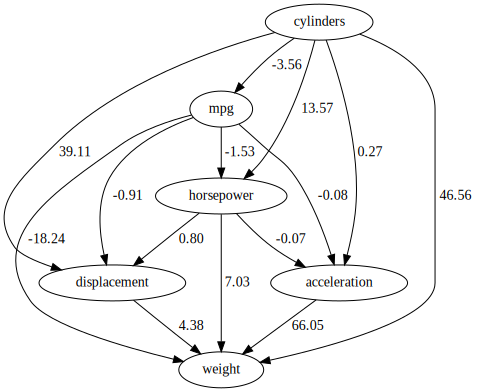

Method : DirectLiNGAM by Kernel Method


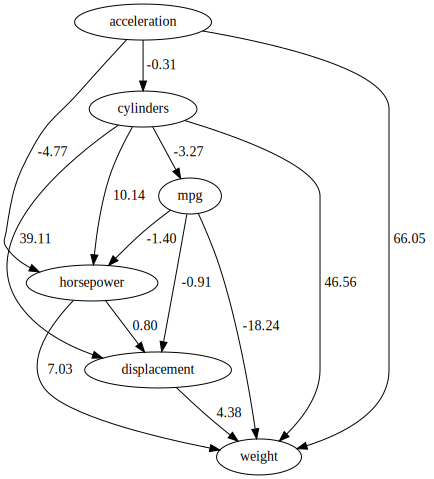

Method : ICALiNGAM


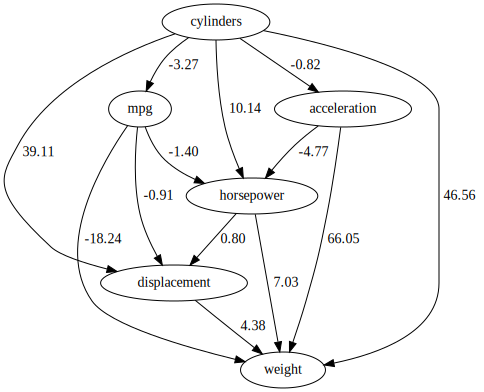

Method : BottomUpParceLiNGAM


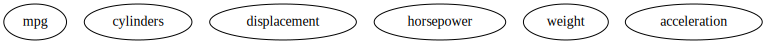

In [37]:
graphs = {}
labels = [f'{col}' for i, col in enumerate(data.columns)]

# DirectLiNGAM
pk = make_prior_knowledge(
    n_variables=len(data.columns),
    sink_variables=[4])
model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(data)
graph_dot = make_graph(model.adjacency_matrix_, labels)
graphs['DirectLiNGAM'] = graph_dot

# DirectLiNGAM by Kernel Method
model = lingam.DirectLiNGAM(measure='kernel')
model.fit(data)
graph_dot = make_graph(model.adjacency_matrix_, labels)
graphs['DirectLiNGAM by Kernel Method'] = graph_dot

# ICALiNGAM
model = lingam.ICALiNGAM()
model.fit(data)
graph_dot = make_graph(model.adjacency_matrix_, labels)
graphs['ICALiNGAM'] = graph_dot

# BottomUpParceLiNGAM
prior_knowledge = make_prior_knowledge(
    n_variables=len(data.columns),
    sink_variables=[4])
model = lingam.BottomUpParceLiNGAM(prior_knowledge=prior_knowledge)
model.fit(data)
graph_dot = make_graph(model.adjacency_matrix_, labels)
graphs['BottomUpParceLiNGAM'] = graph_dot

# Visualize graphs
for method, graph in graphs.items():
    print("Method : %s"%(method))
    display(graph)

## Estimate effects using Linear Regression

In [38]:
for method, graph in graphs.items():
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = data,
                treatment='mpg',
                outcome='weight',
                graph=graph)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimation
        estimate = model.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                        control_value=0,
                                        treatment_value=1,
                                        confidence_intervals=True,
                                        test_significance=True)
        print(estimate)
        print("Causal Estimate is " + str(estimate.value))


*****************************************************************************

Causal Discovery Method : DirectLiNGAM
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                  
──────(Expectation(weight|cylinders))
d[mpg]                               
Estimand assumption 1, Unconfoundedness: If U→{mpg} and U→weight then P(weight|mpg,cylinders,U) = P(weight|mpg,cylinders)

## Realized estimand
b: weight~mpg+cylinders
Target units: ate

## Estimate
Mean value: -36.97546905326499
p-value: [0.]
95.0% confidence interval: [[-43.631 -30.319]]

Causal Estimate is -36.97546905326499

*****************************************************************************

Causal Discovery Method : DirectLiNGAM by Kernel Method
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d          

## Estimate effects using Double ML

In [43]:
import econml
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor

for method, graph in graphs.items():
        print('\n*****************************************************************************\n')
        print("Causal Discovery Method : %s"%(method))

        # Obtain valid dot format
        graph = str_to_dot(graph.source)

        # Define Causal Model
        model=CausalModel(
                data = data,
                treatment='mpg',
                outcome='weight',
                graph=graph)

        # Identification
        identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

        # Estimation
        dml_estimate = model.estimate_effect(identified_estimand, 
                                            method_name="backdoor.econml.dml.DML",
                                            method_params={
                                                'init_params': {'model_y':GradientBoostingRegressor(),
                                                                'model_t': GradientBoostingRegressor(),
                                                                'model_final':LassoCV(fit_intercept=False), },
                                                'fit_params': {}
                                            })
        print(estimate)
        print("Causal Estimate is " + str(estimate.value))


*****************************************************************************

Causal Discovery Method : DirectLiNGAM
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                       
──────(Expectation(weight|cylinders,acceleration,displacement,horsepower))
d[mpg]                                                                    
Estimand assumption 1, Unconfoundedness: If U→{mpg} and U→weight then P(weight|mpg,cylinders,acceleration,displacement,horsepower,U) = P(weight|mpg,cylinders,acceleration,displacement,horsepower)

## Realized estimand
b: weight~mpg+cylinders+acce